# Dataset and Preprocessing

## Data Loading

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Flatten images for preprocessing
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Split into training (80%) and validation (20%) sets
X_train_flat, X_val_flat, y_train, y_val = train_test_split(
    X_train_flat, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Print dataset shapes to verify correctness
print(f"Training set shape: {X_train_flat.shape}, Labels: {y_train.shape}")
print(f"Validation set shape: {X_val_flat.shape}, Labels: {y_val.shape}")
print(f"Test set shape: {X_test_flat.shape}, Labels: {y_test.shape}")


Training set shape: (48000, 784), Labels: (48000,)
Validation set shape: (12000, 784), Labels: (12000,)
Test set shape: (10000, 784), Labels: (10000,)


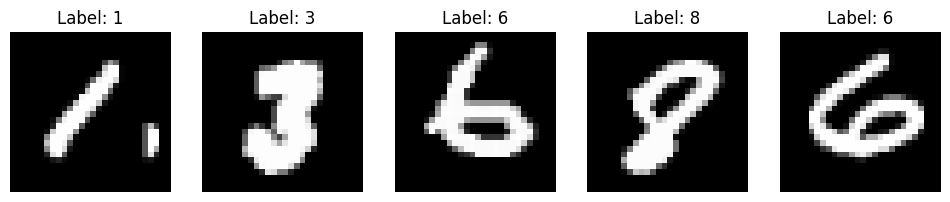

In [4]:

# Display a few sample images from the training set
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(X_train_flat[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.show()

## Data Analysis

### Compute & Display Class Distribution



<ipython-input-5-f79745c7e42a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="viridis")


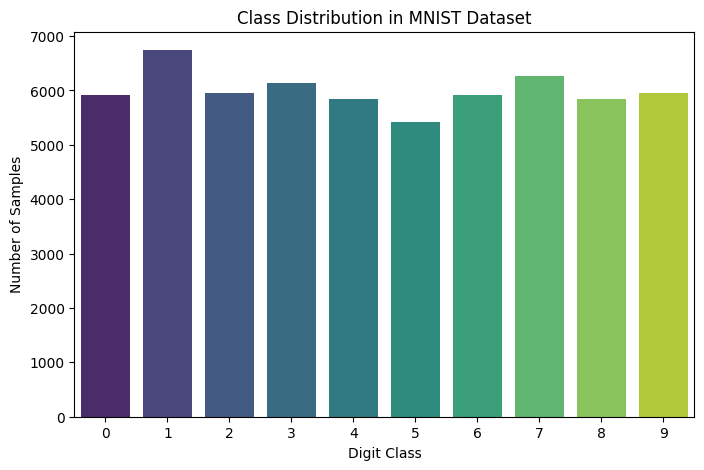

In [5]:
# Compute class distribution
unique, counts = np.unique(y_train_full, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="viridis")
plt.xlabel("Digit Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in MNIST Dataset")
plt.show()


### Compute & Display Basic Statistics

In [6]:
# Compute overall mean and standard deviation of pixel values
mean_pixel_value = np.mean(X_train_full)
std_pixel_value = np.std(X_train_full)

print(f"Mean Pixel Value: {mean_pixel_value:.4f}")
print(f"Standard Deviation of Pixel Values: {std_pixel_value:.4f}")

# Compute mean & std for each class (optional)
class_means = [np.mean(X_train_full[y_train_full == i]) for i in range(10)]
class_stds = [np.std(X_train_full[y_train_full == i]) for i in range(10)]

# Display class-wise statistics
for i in range(10):
    print(f"Digit {i}: Mean = {class_means[i]:.4f}, Std = {class_stds[i]:.4f}")


Mean Pixel Value: 33.3184
Standard Deviation of Pixel Values: 78.5675
Digit 0: Mean = 44.2168, Std = 88.6681
Digit 1: Mean = 19.3797, Std = 62.2918
Digit 2: Mean = 37.9887, Std = 83.1105
Digit 3: Mean = 36.0902, Std = 81.0692
Digit 4: Mean = 30.9482, Std = 75.8585
Digit 5: Mean = 32.8311, Std = 77.4151
Digit 6: Mean = 35.0120, Std = 80.2989
Digit 7: Mean = 29.2046, Std = 74.3824
Digit 8: Mean = 38.2898, Std = 82.9413
Digit 9: Mean = 31.2604, Std = 76.1526


### Display One Sample Image for Each Digit

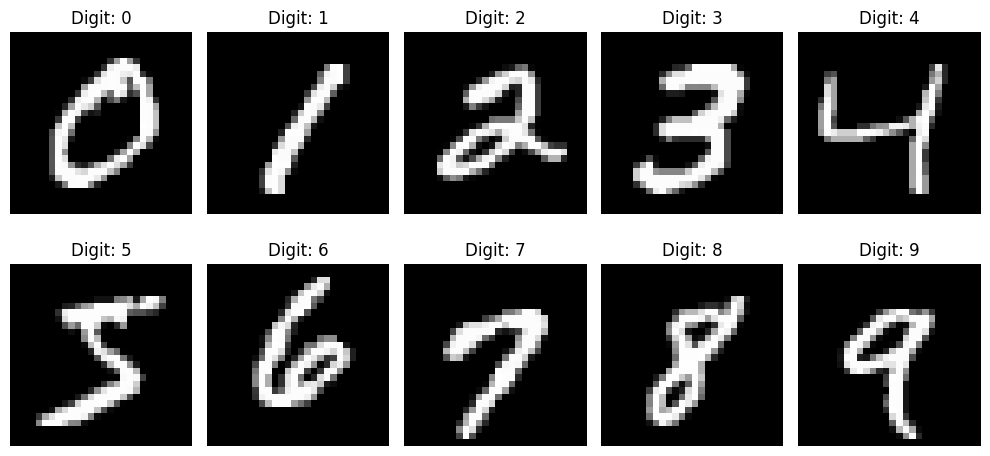

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()  # Flatten axes array for easy iteration

# Show one sample per digit
for i in range(10):
    idx = np.where(y_train_full == i)[0][0]  # Find first occurrence of each digit
    axes[i].imshow(X_train_full[idx].reshape(28, 28), cmap="gray")
    axes[i].set_title(f"Digit: {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## Data Preprocessing

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Apply Standardization (Mean = 0, Std = 1)
scaler_std = StandardScaler()
X_train_standardized = scaler_std.fit_transform(X_train_flat)
X_val_standardized = scaler_std.transform(X_val_flat)
X_test_standardized = scaler_std.transform(X_test_flat)

# Apply Normalization (Alternative: MinMaxScaler to [0,1] range)
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_flat)
X_val_minmax = scaler_minmax.transform(X_val_flat)
X_test_minmax = scaler_minmax.transform(X_test_flat)

# Reshape back to (28, 28, 1) for CNN compatibility
X_train_standardized = X_train_standardized.reshape(-1, 28, 28, 1)
X_val_standardized = X_val_standardized.reshape(-1, 28, 28, 1)
X_test_standardized = X_test_standardized.reshape(-1, 28, 28, 1)

X_train_minmax = X_train_minmax.reshape(-1, 28, 28, 1)
X_val_minmax = X_val_minmax.reshape(-1, 28, 28, 1)
X_test_minmax = X_test_minmax.reshape(-1, 28, 28, 1)


In [9]:
# Print statistics to verify normalization
print(f"\nMean after Standardization: {X_train_standardized.mean():.4f}, Std: {X_train_standardized.std():.4f}")
print(f"Min pixel value after MinMax Scaling: {X_train_minmax.min()}, Max: {X_train_minmax.max()}")


Mean after Standardization: -0.0000, Std: 0.9530
Min pixel value after MinMax Scaling: 0.0, Max: 1.0


# k-NN Classifier

## Model Initialization and Hyperparameter Tuning

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define k-values to experiment with
k_values = [1, 3, 5, 7, 9]
validation_accuracies = []

# Train k-NN classifiers with different k-values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_flat, y_train)  # Train on flattened data
    y_val_pred = knn.predict(X_val_flat)  # Predict validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)  # Compute accuracy
    validation_accuracies.append(val_accuracy)
    print(f"k={k}, Validation Accuracy: {val_accuracy:.4f}")

# Find best k-value
best_k = k_values[np.argmax(validation_accuracies)]
print(f"\nBest k: {best_k} with Validation Accuracy: {max(validation_accuracies):.4f}")



k=1, Validation Accuracy: 0.9704
k=3, Validation Accuracy: 0.9703
k=5, Validation Accuracy: 0.9675
k=7, Validation Accuracy: 0.9663
k=9, Validation Accuracy: 0.9654

Best k: 1 with Validation Accuracy: 0.9704


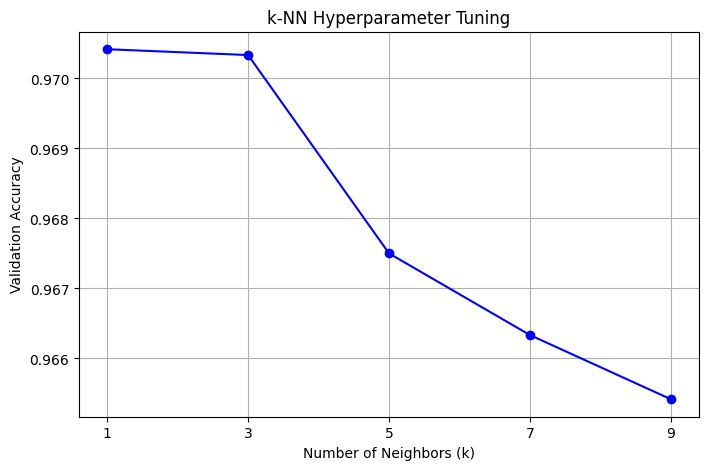

In [11]:
# Plot validation accuracy vs. k-values
plt.figure(figsize=(8, 5))
plt.plot(k_values, validation_accuracies, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.title("k-NN Hyperparameter Tuning")
plt.xticks(k_values)
plt.grid(True)
plt.show()

## Final Model Training and Evaluation

### Retrain k-NN with Best Hyperparameter

In [12]:
# Combine training and validation sets for final training
X_train_final = np.concatenate((X_train_flat, X_val_flat), axis=0)
y_train_final = np.concatenate((y_train, y_val), axis=0)

# Train k-NN with the best k-value
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_final, y_train_final)

# Predict on the test set
y_test_pred = final_knn.predict(X_test_flat)


### Evaluate Model Performance

In [13]:
from sklearn.metrics import classification_report, accuracy_score

# Print Accuracy
accuracy_knn = accuracy_score(y_test, y_test_pred)
print(f"KNN Test Accuracy: {accuracy_knn:.4f}")

# Print Classification Report
print("Classification Report for k-NN:")
print(classification_report(y_test, y_test_pred))


KNN Test Accuracy: 0.9691
Classification Report for k-NN:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Generate and Visualize Confusion Matrix

<Figure size 800x600 with 0 Axes>

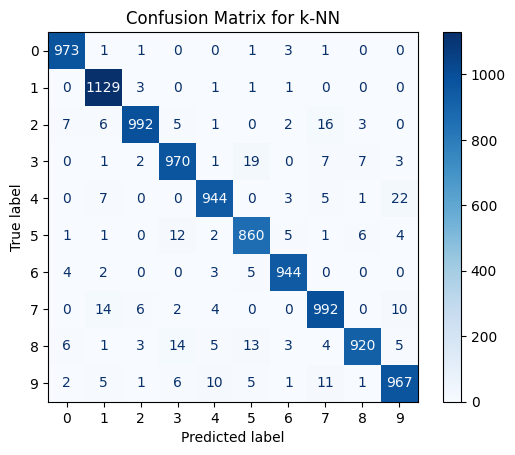

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_knn = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm_knn, display_labels=np.arange(10)).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for k-NN")
plt.show()


### Discuss Misclassified Digits

In [15]:
# Find the most misclassified digits
misclassified_counts = np.sum(cm_knn, axis=1) - np.diag(cm_knn)

# Print most misclassified digits
most_misclassified = np.argsort(misclassified_counts)[-3:]  # Top 3 most misclassified digits
print(f"Most misclassified digits: {most_misclassified}")


Most misclassified digits: [3 9 8]


### Display 5 Random Misclassified Examples


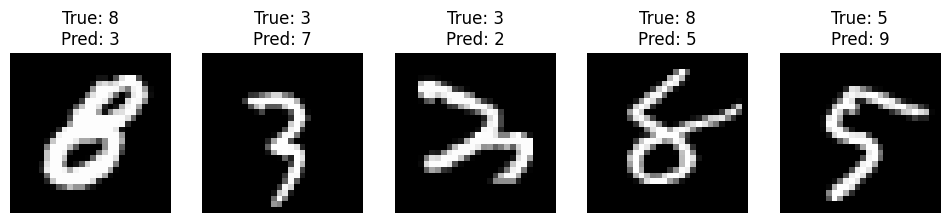

In [16]:
import random

# Find misclassified indices
misclassified_idx = np.where(y_test != y_test_pred)[0]

# Select 5 random misclassified images
random_misclassified = random.sample(list(misclassified_idx), 5)

# Plot misclassified images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes):
    idx = random_misclassified[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[idx]}\nPred: {y_test_pred[idx]}")
    ax.axis("off")

plt.show()


### Display 5 most common Misclassified Examples

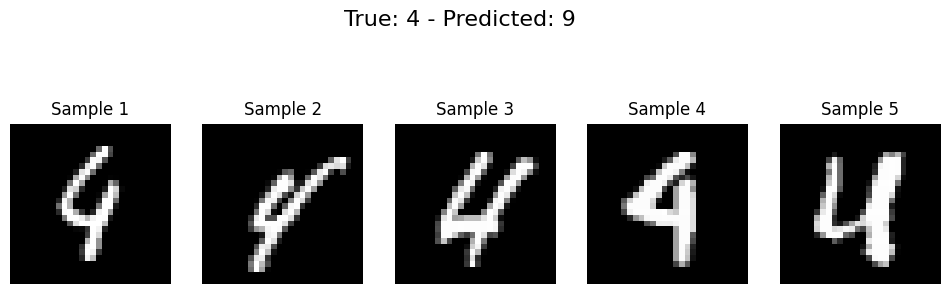

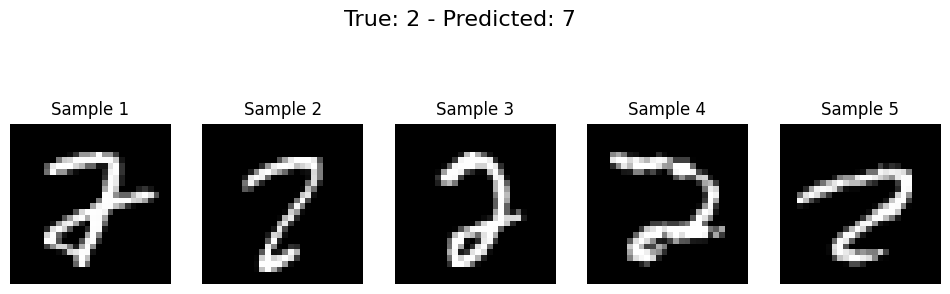

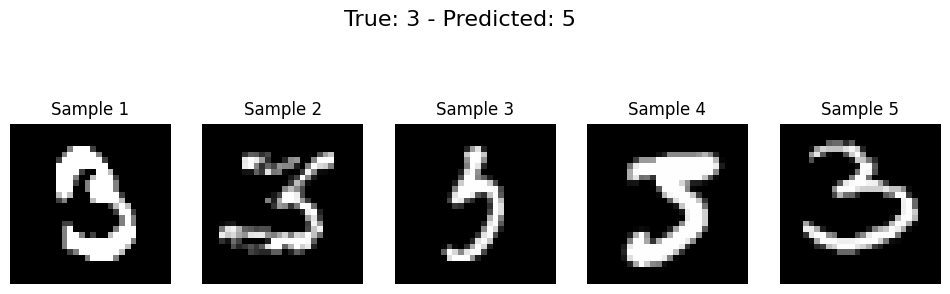

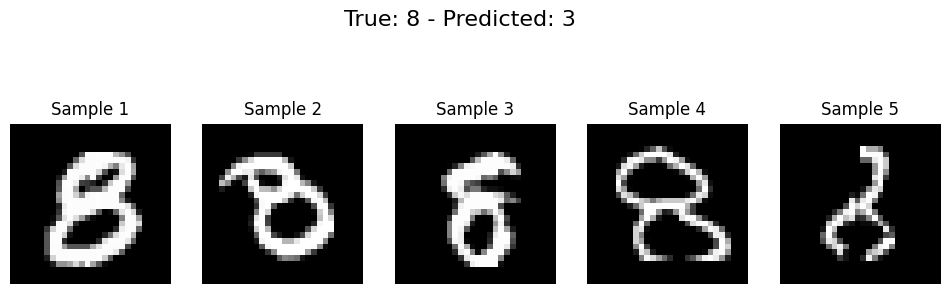

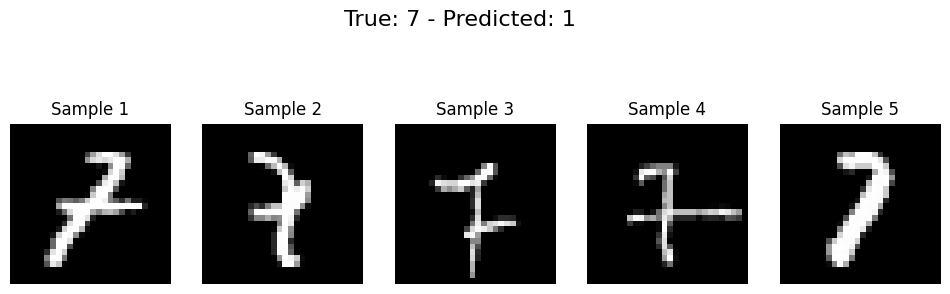

In [17]:
# Define the most common misclassifications
misclassification_pairs = [
    (4, 9),
    (2, 7),
    (3, 5),
    (8, 3),
    (7, 1)
]

# Plot 5 random misclassified images for each pair
for true_label, predicted_label in misclassification_pairs:
    # Find indices where true label matches and predicted label matches the misclassification
    misclassified_indices = np.where((y_test == true_label) & (y_test_pred == predicted_label))[0]

    # Randomly select up to 5 samples for visualization
    num_samples = min(5, len(misclassified_indices))
    if num_samples > 0:
        selected_indices = random.sample(list(misclassified_indices), num_samples)

        # Plot the images
        fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
        fig.suptitle(f"True: {true_label} - Predicted: {predicted_label}", fontsize=16)
        for i, ax in enumerate(axes):
            idx = selected_indices[i]
            ax.imshow(X_test[idx].reshape(28, 28), cmap="gray")
            ax.set_title(f"Sample {i+1}")
            ax.axis("off")
        plt.show()
    else:
        print(f"No misclassified samples found for True: {true_label}, Predicted: {predicted_label}")


# Decision Tree Classifier

## Model Training and Hyperparameter Tuning

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define hyperparameter grid
param_grid = {
    "max_depth": [2, 5, 10],
    "min_samples_split": [2, 5]
}

# Initialize Decision Tree Classifier
tree_classifier = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=tree_classifier,
    param_grid=param_grid,
    cv=3,  # 3-Fold Cross Validation
    scoring="accuracy",
    n_jobs=-1
)

# Train the Decision Tree with different hyperparameter combinations
grid_search.fit(X_train_flat, y_train)



GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10], 'min_samples_split': [2, 5]},
             scoring='accuracy')

### Documenting Results

In [19]:
# Print best hyperparameters and corresponding accuracy
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Display all results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Extract the relevant information for the report
results_summary = results[[
    "param_max_depth",
    "param_min_samples_split",
    "mean_test_score"
]].sort_values(by="mean_test_score", ascending=False)

# Display the table in a readable format
print("\nValidation Accuracy for Each Hyperparameter Combination:")
print(results_summary)

# Convert the table for easy copy-pasting into LaTeX format
for index, row in results_summary.iterrows():
    print(f"{row['param_max_depth']} & {row['param_min_samples_split']} & {row['mean_test_score']:.4f} \\\\")

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5}
Best Cross-Validation Accuracy: 0.8445

Validation Accuracy for Each Hyperparameter Combination:
   param_max_depth  param_min_samples_split  mean_test_score
5               10                        5         0.844500
4               10                        2         0.844271
2                5                        2         0.680292
3                5                        5         0.680292
0                2                        2         0.336542
1                2                        5         0.336542
10.0 & 5.0 & 0.8445 \\
10.0 & 2.0 & 0.8443 \\
5.0 & 2.0 & 0.6803 \\
5.0 & 5.0 & 0.6803 \\
2.0 & 2.0 & 0.3365 \\
2.0 & 5.0 & 0.3365 \\


## Evaluation

### Evaluate the Final Model

In [20]:
from sklearn.metrics import classification_report, accuracy_score

# Use the best Decision Tree model from Grid Search
best_tree_classifier = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
best_tree_classifier.fit(X_train_flat, y_train)

# Predict on test set
y_test_pred_tree = best_tree_classifier.predict(X_test_flat)

# Compute Accuracy
accuracy_tree = accuracy_score(y_test, y_test_pred_tree)
print(f"Decision Tree Test Accuracy: {accuracy_tree:.4f}")

# Print Classification Report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_test_pred_tree))


Decision Tree Test Accuracy: 0.8608
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.95      0.94      0.94      1135
           2       0.85      0.83      0.84      1032
           3       0.83      0.82      0.82      1010
           4       0.87      0.84      0.86       982
           5       0.83      0.81      0.82       892
           6       0.88      0.88      0.88       958
           7       0.90      0.87      0.89      1028
           8       0.79      0.78      0.79       974
           9       0.78      0.88      0.83      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### Generate and Analyze the Confusion Matrix

<Figure size 800x600 with 0 Axes>

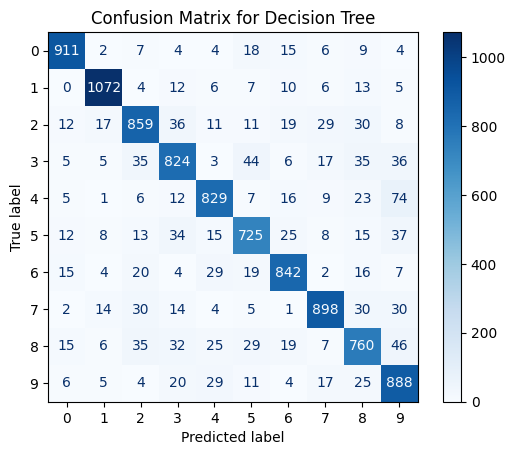

Most misclassified digits: [2 3 8]


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_tree = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm_tree, display_labels=np.arange(10)).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

# Find the most frequently misclassified digits
misclassified_counts_tree = np.sum(cm_tree, axis=1) - np.diag(cm_tree)
most_misclassified_tree = np.argsort(misclassified_counts_tree)[-3:]
print(f"Most misclassified digits: {most_misclassified_tree}")


### Plot Multi-Class ROC Curve

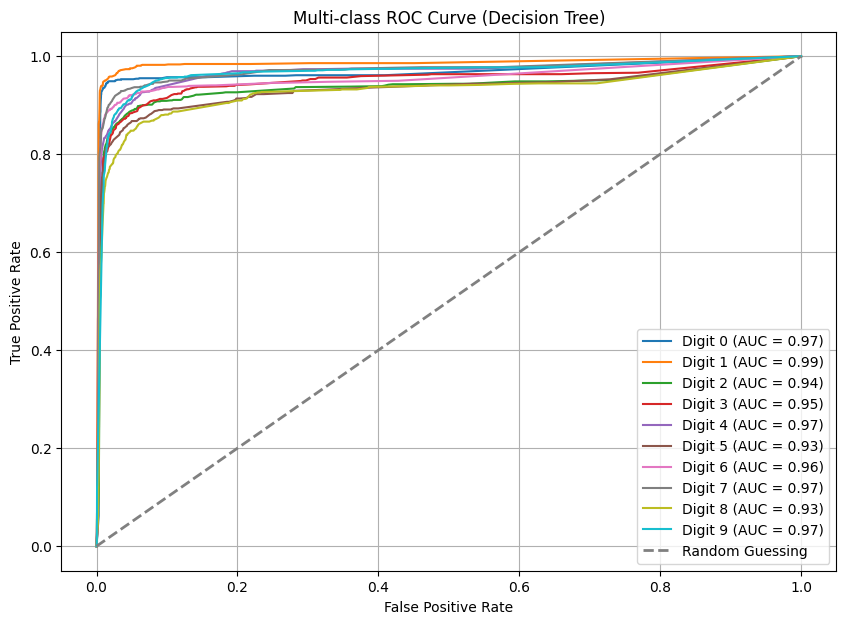

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=np.arange(10))
y_test_proba_tree = best_tree_classifier.predict_proba(X_test_flat)

plt.figure(figsize=(10, 7))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba_tree[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Digit {i} (AUC = {roc_auc:.2f})")

# Reference lines
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (Decision Tree)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


### Visualize the Full Decision Tree

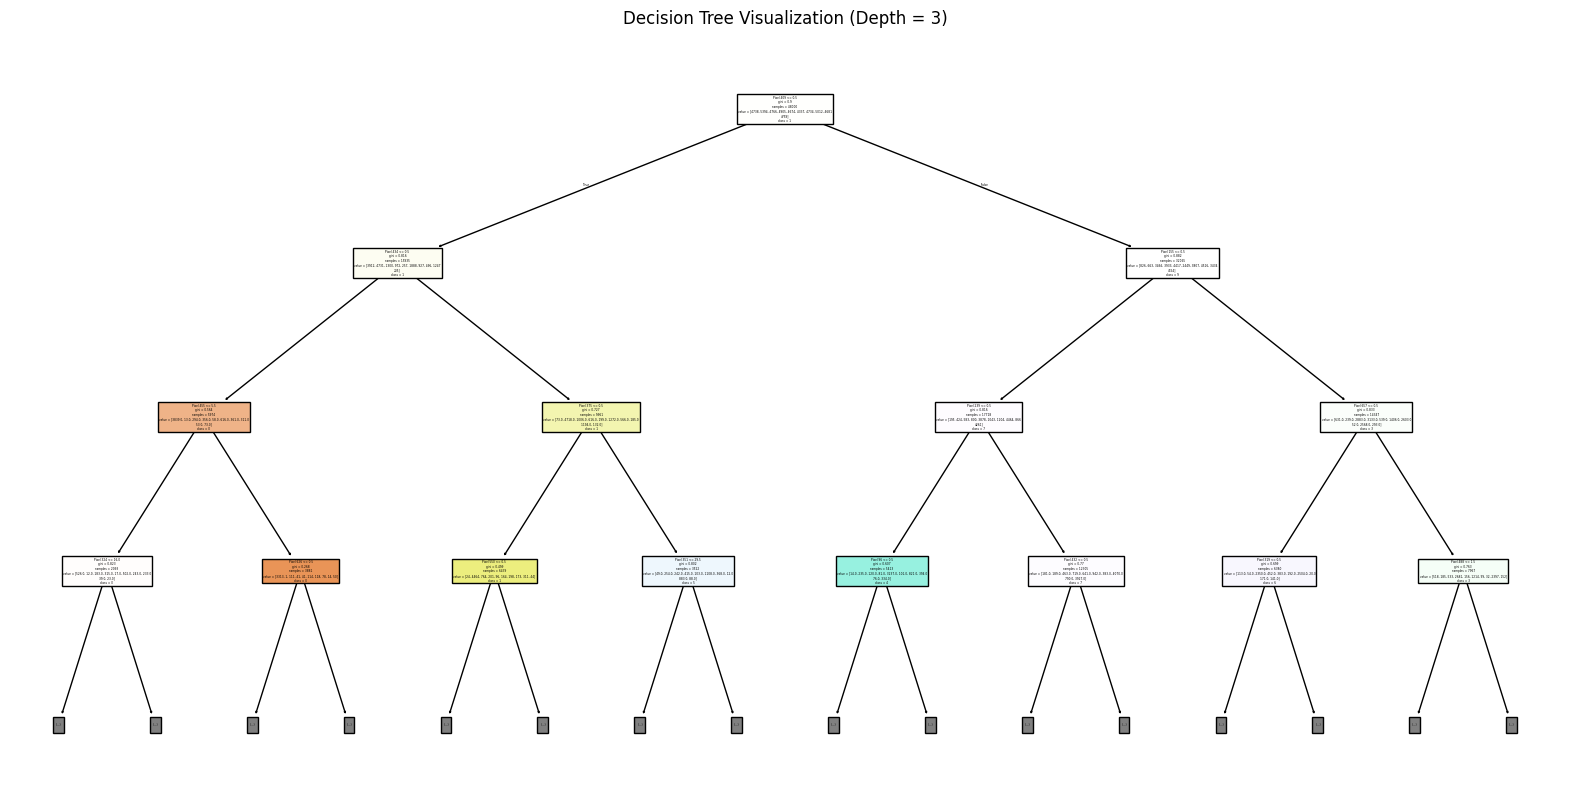

In [23]:
from sklearn.tree import plot_tree

# Plot the entire Decision Tree (may be too large)
plt.figure(figsize=(20, 10))
plot_tree(best_tree_classifier, filled=True, feature_names=[f"Pixel {i}" for i in range(784)], class_names=[str(i) for i in range(10)], max_depth=3)
plt.title("Decision Tree Visualization (Depth = 3)")
plt.show()


## Additional

### Extract Important Features (Pixels)

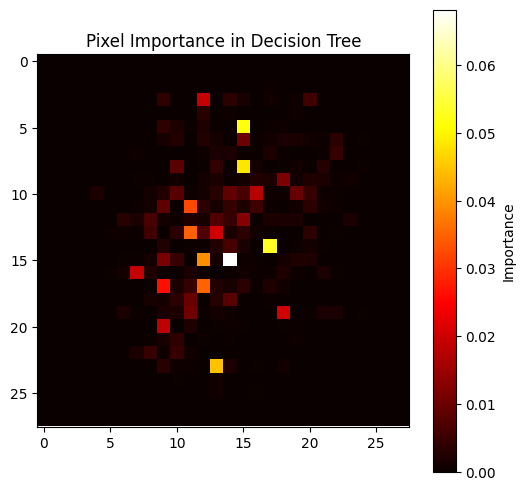

In [24]:
# Get feature importance
feature_importance = best_tree_classifier.feature_importances_

# Reshape into 28x28 image to see which pixels matter most
importance_image = feature_importance.reshape(28, 28)

# Plot the pixel importance heatmap
plt.figure(figsize=(6, 6))
plt.imshow(importance_image, cmap="hot", interpolation="nearest")
plt.colorbar(label="Importance")
plt.title("Pixel Importance in Decision Tree")
plt.show()
